A Guide to Time Series Forecasting with ARIMA in Python 3

See https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [5]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from datetime import datetime
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from tkinter import *
from tkinter import filedialog

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [2]:
def get_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data", title = "Select PRIM master file",\
                        filetypes = (("Prim files","*.prim"),("Seco files","*.seco"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp1 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B'),
    ('P9', 'B'),('P10', 'B'),('P11', 'B'),('P12', 'B')])
pp2 = np.dtype([('p1', 'f'),('p2', 'f'),('p3', 'f'),('p4', 'f')])

rectype = np.dtype([
    ('Procid',pp1),
    ('Loc','i'),
#    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'), 
    ('date_val','i2',(12)),
    ('Hsig','f'), ('Thsig','f'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2',pp2)])

# Get name of input PRIM file
Input_Prim_File = get_file()

# Open file
f = open(Input_Prim_File)

# Read data from the Binary file into a DF based on the structure in the DT
data = np.fromfile(f, rectype)
recs = DataFrame.from_records(np.array(data).tolist())

# Assign column names to DF
recs.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz',
                'H10','Th10','Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

# Locate, and remove errant zero's from data
zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index
if len(zero_data) > 0:
    recs_zero = recs    # make a copy to locate where the zeros occur
    date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
    ' '.join(str(p) for p in [date_string])
    last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
        +':'+str(date_string[4])
    print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)
else:
    print('No zeros found in ',Input_Prim_File)
    
recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]

# Convert date/time column data into Dates and times
Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
        columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

# Insert Date column at start of DF
recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

# Remove unwanted columns from the DF
recs = recs.drop(columns=[
    'Procid',
    'Loc',
    'date_val',
    'Param2'], axis=1)

# get Hmax
y = recs.Hm0/recs.Hsig
##print(y)

# The 'MS' string groups the data in buckets by start of the month
y = y.resample('MS').max()
###y = y.resample('6H').max() # <= causes Memory Error !!!

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.prim


The primary concern is to ensure that the residuals of the model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

Note: An MSE of 0 would indicate that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code below, we specify the start of computing dynamic forecasts and confidence intervals from January 2000 onwards.

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y[str(min(y.index.year)):].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Hmax')

plt.legend()
plt.show()

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2010-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

Extrapolate the seasonal ARIMA time series model to forecast future values. The get_forecast() attribute can compute forecasted values for a specified number of steps ahead.

In [35]:
details = recs.describe()
details.Tc

count    370420.000000
mean          5.351086
std           1.258251
min           2.290993
25%           4.336257
50%           5.336148
75%           6.230751
max          11.847727
Name: Tc, dtype: float64

In [36]:
details.Tc[4]

4.336256980895996

In [ ]:
plt.figure(figsize=(15,20),dpi=100)
recs.boxplot(column=['Hsig','Hm0','Hrms','H10','Hmax','Tz','T02','Tp'],notch=True,patch_artist=True)

In [13]:
suspect_Hmax_Hsig = recs[~(recs.Hmax/recs.Hsig).between(1.4,2.5,inclusive=False)]
suspect_Hm0_Hsig = recs[~(recs.Hm0/recs.Hsig).between(1.0,1.3,inclusive=False)]
suspect_Hrms_Hsig = recs[~(recs.Hrms/recs.Hsig).between(0.67,0.95,inclusive=False)]
suspect_Tz_T02 = recs[~(recs.Tz/recs.T02).between(0.8,1.3,inclusive=False)]
suspect_Tp = recs[~(recs.Tp).between(1.0,16.0,inclusive=False)]
suspect_Hs_or_Hmax = recs[np.logical_or(recs.Hsig>5, recs.Hmax>10)]
suspect_Tp_or_Tzmax = recs[np.logical_or(recs.Tp>21, recs.Tzmax>21)]
suspect_Thsig_or_Tc_or_Tz = recs[np.logical_or.reduce([recs.Thsig>14, recs.Tc>14, recs.Tz>14])]

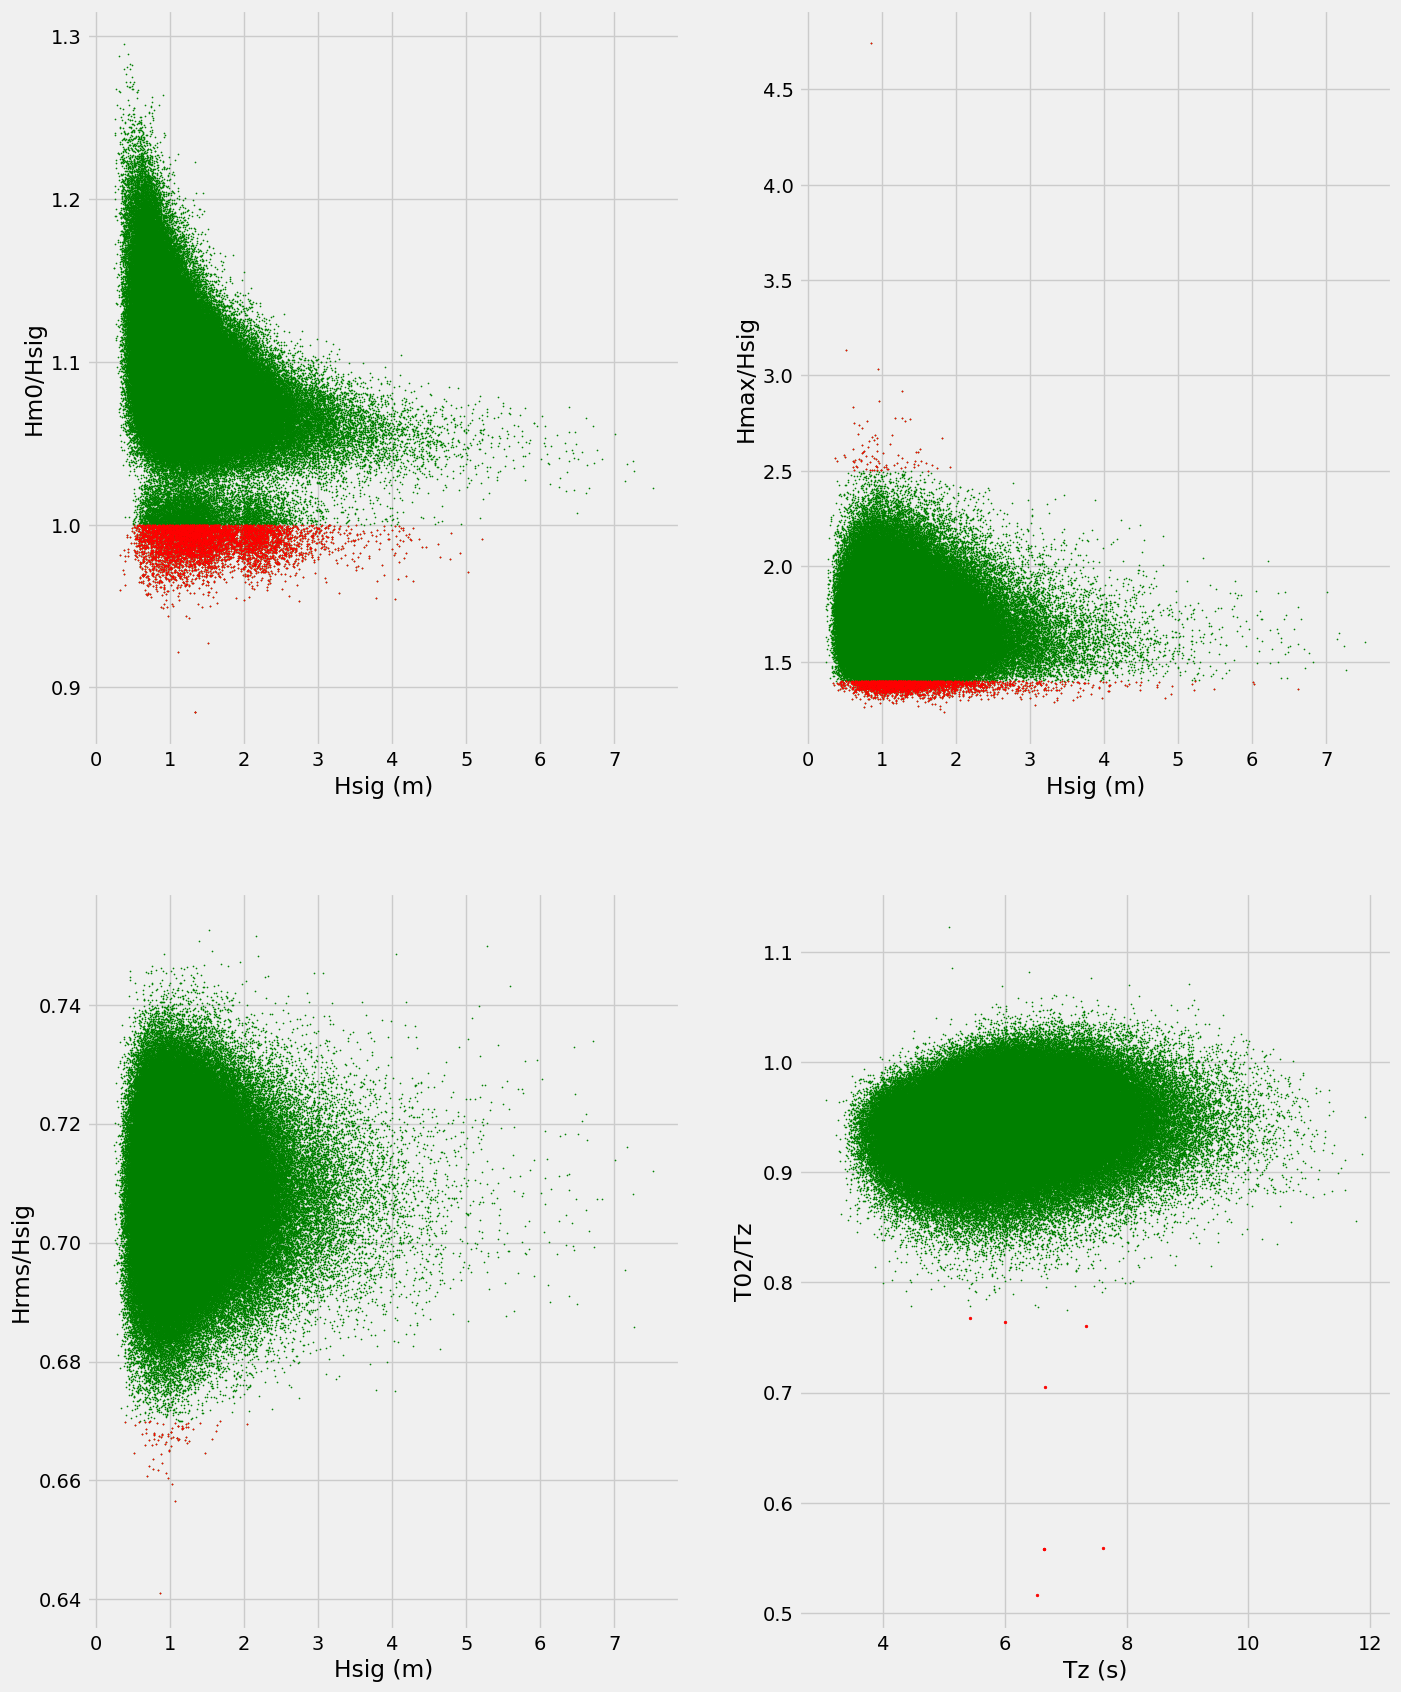

In [29]:
details = recs.describe()

plt.figure(figsize=(15,20),dpi=100)

plt.subplot(221)
plt.scatter(recs.Hsig,recs.Hm0/recs.Hsig,s=0.5,c='g')
suspect_Hm0_Hsig = recs[~(recs.Hm0/recs.Hsig).between(1.0,1.3,inclusive=False)]
plt.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=0.5,c='r')
plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")

plt.subplot(222)
plt.scatter(recs.Hsig,recs.Hmax/recs.Hsig,s=0.5,c='g')
suspect_Hmax_Hsig = recs[~(recs.Hmax/recs.Hsig).between(1.4,2.5,inclusive=False)]
plt.scatter(suspect_Hmax_Hsig.Hsig,suspect_Hmax_Hsig.Hmax/suspect_Hmax_Hsig.Hsig,s=0.5,c='r')
plt.xlabel("Hsig (m)")
plt.ylabel("Hmax/Hsig")

plt.subplot(223)
plt.scatter(recs.Hsig,recs.Hrms/recs.Hsig,s=0.5,c='g')
suspect_Hrms_Hsig = recs[~(recs.Hrms/recs.Hsig).between(0.67,0.95,inclusive=False)]
plt.scatter(suspect_Hrms_Hsig.Hsig,suspect_Hrms_Hsig.Hrms/suspect_Hrms_Hsig.Hsig,s=0.5,c='r')
plt.xlabel("Hsig (m)")
plt.ylabel("Hrms/Hsig")

plt.subplot(224)
plt.scatter(recs.Tz,recs.T02/recs.Tz,s=0.5,c='g')
suspect_Tz_T02 = recs[~(recs.Tz/recs.T02).between(0.8,1.3,inclusive=False)]
plt.scatter(suspect_Tz_T02.Tz,suspect_Tz_T02.T02/suspect_Tz_T02.Tz,s=3.5,c='r')
plt.xlabel("Tz (s)")
plt.ylabel("T02/Tz")

plt.show()

In [28]:
len(suspect_Tz_T02)

8